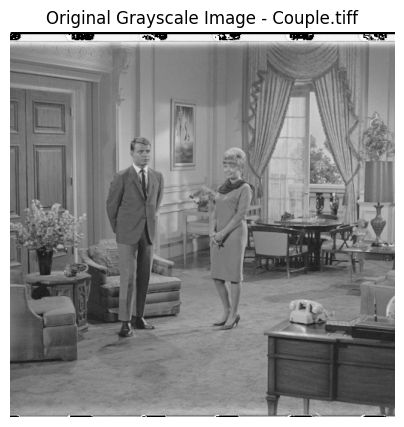

Image Size: (512, 512)


In [3]:
# ==========================
# Question 2 - Adaptive Histogram Equalization
# Part 1: Load and Prepare the Grayscale Image
# ==========================

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image (already uploaded in Colab)
img = cv2.imread('Couple.tiff', cv2.IMREAD_GRAYSCALE)

# Show original image
plt.figure(figsize=(5,5))
plt.title("Original Grayscale Image - Couple.tiff")
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

print("Image Size:", img.shape)


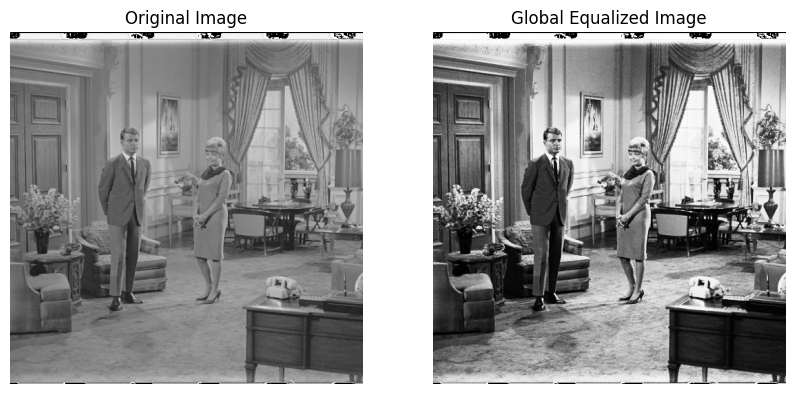

In [4]:
# ==========================
# Part 2: Global Histogram Equalization
# ==========================

def global_hist_equalization(image):
    hist, bins = np.histogram(image.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * (255 / cdf[-1])
    equalized = np.interp(image.flatten(), bins[:-1], cdf_normalized)
    return equalized.reshape(image.shape).astype(np.uint8)

global_eq = global_hist_equalization(img)

# Display comparison
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img, cmap='gray'); plt.axis('off')
plt.subplot(1,2,2)
plt.title("Global Equalized Image")
plt.imshow(global_eq, cmap='gray'); plt.axis('off')
plt.show()


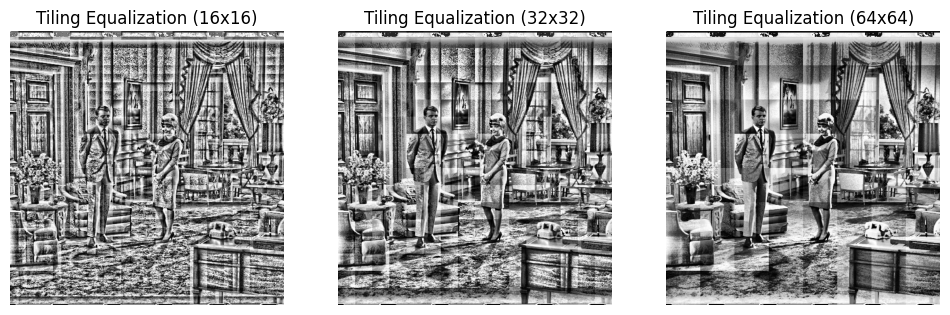

In [5]:
# ==========================
# Part 3: Adaptive Histogram Equalization - Tiling Approach
# ==========================

def adaptive_hist_equalization_tiling(image, tile_size):
    h, w = image.shape
    output = np.zeros_like(image)

    for i in range(0, h, tile_size):
        for j in range(0, w, tile_size):
            block = image[i:min(i+tile_size, h), j:min(j+tile_size, w)]
            eq_block = global_hist_equalization(block)
            output[i:min(i+tile_size, h), j:min(j+tile_size, w)] = eq_block
    return output

tile_sizes = [16, 32, 64]
tiling_results = {}

plt.figure(figsize=(12,4))
for idx, size in enumerate(tile_sizes):
    result = adaptive_hist_equalization_tiling(img, size)
    tiling_results[size] = result
    plt.subplot(1,3,idx+1)
    plt.title(f"Tiling Equalization ({size}x{size})")
    plt.imshow(result, cmap='gray'); plt.axis('off')
plt.show()


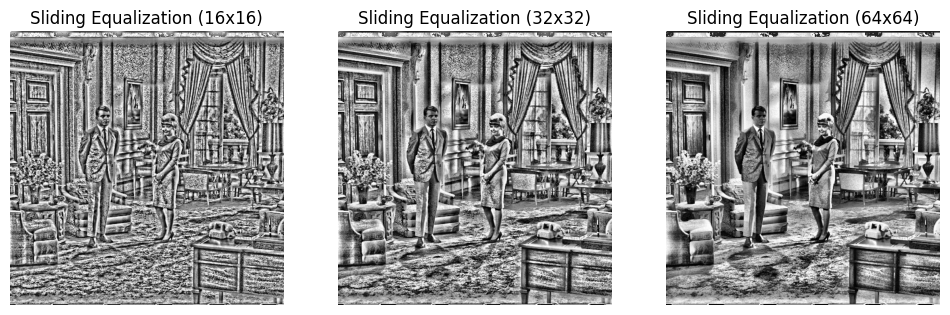

In [6]:
# ==========================
# Part 4: Adaptive Histogram Equalization - Sliding Window Approach
# ==========================

def adaptive_hist_equalization_sliding(image, window_size):
    pad = window_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    output = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            local = padded[i:i+window_size, j:j+window_size]
            eq_local = global_hist_equalization(local)
            output[i,j] = eq_local[pad, pad]
    return output

window_sizes = [16, 32, 64]
sliding_results = {}

plt.figure(figsize=(12,4))
for idx, size in enumerate(window_sizes):
    result = adaptive_hist_equalization_sliding(img, size)
    sliding_results[size] = result
    plt.subplot(1,3,idx+1)
    plt.title(f"Sliding Equalization ({size}x{size})")
    plt.imshow(result, cmap='gray'); plt.axis('off')
plt.show()


In [7]:
# ==========================
# Part 5: Metrics - Entropy and PSNR
# ==========================

def entropy(image):
    hist, _ = np.histogram(image.flatten(), 256, [0,256])
    p = hist / np.sum(hist)
    p = p[p > 0]
    return -np.sum(p * np.log2(p))

def psnr(original, processed):
    mse = np.mean((original - processed) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(255 / np.sqrt(mse))

results = {
    'Global': (entropy(global_eq), psnr(img, global_eq))
}

for size in tile_sizes:
    e = entropy(tiling_results[size])
    p = psnr(img, tiling_results[size])
    results[f'Tiling {size}x{size}'] = (e, p)

for size in window_sizes:
    e = entropy(sliding_results[size])
    p = psnr(img, sliding_results[size])
    results[f'Sliding {size}x{size}'] = (e, p)

# نمایش نتایج به صورت جدول
import pandas as pd
df = pd.DataFrame(results, index=["Entropy", "PSNR"]).T
print(df)


                Entropy       PSNR
Global         7.010607  27.778518
Tiling 16x16   7.987327  27.849852
Tiling 32x32   7.980743  27.816464
Tiling 64x64   7.954547  27.823087
Sliding 16x16  7.969719  27.852971
Sliding 32x32  7.975970  27.875259
Sliding 64x64  7.975401  27.864266


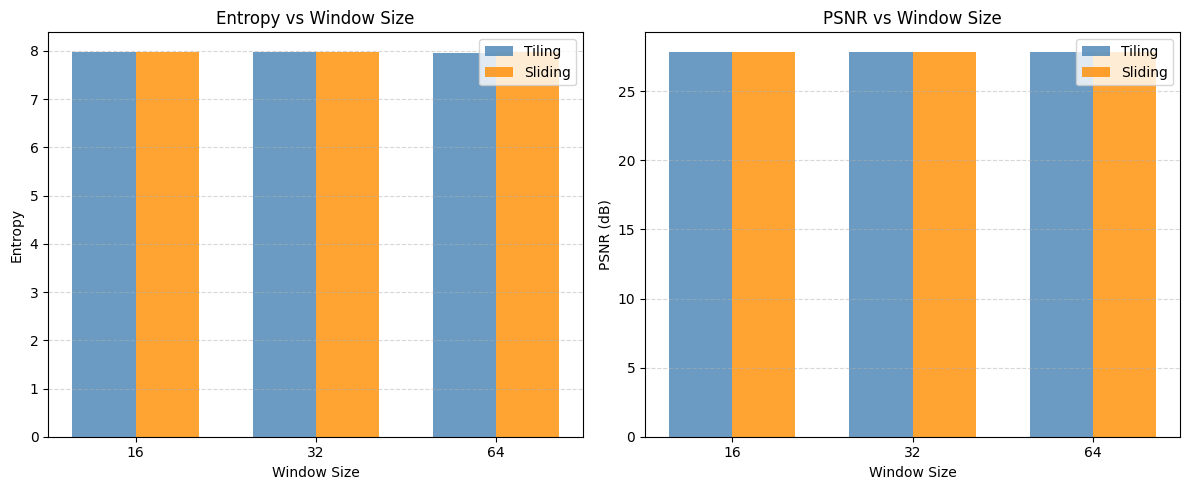

In [8]:
# ==========================
# Part 6 (Fixed): Plot Entropy and PSNR vs Window Size for Each Method
# ==========================

entropy_tiling = [entropy(tiling_results[s]) for s in tile_sizes]
entropy_sliding = [entropy(sliding_results[s]) for s in window_sizes]

psnr_tiling = [psnr(img, tiling_results[s]) for s in tile_sizes]
psnr_sliding = [psnr(img, sliding_results[s]) for s in window_sizes]

# برای قرار دادن میله‌ها کنار هم
x = np.arange(len(tile_sizes))
width = 0.35  # عرض میله

plt.figure(figsize=(12,5))

# --- نمودار Entropy ---
plt.subplot(1,2,1)
plt.bar(x - width/2, entropy_tiling, width, label="Tiling", color='steelblue', alpha=0.8)
plt.bar(x + width/2, entropy_sliding, width, label="Sliding", color='darkorange', alpha=0.8)
plt.xticks(x, [str(s) for s in tile_sizes])
plt.title("Entropy vs Window Size")
plt.xlabel("Window Size")
plt.ylabel("Entropy")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# --- نمودار PSNR ---
plt.subplot(1,2,2)
plt.bar(x - width/2, psnr_tiling, width, label="Tiling", color='steelblue', alpha=0.8)
plt.bar(x + width/2, psnr_sliding, width, label="Sliding", color='darkorange', alpha=0.8)
plt.xticks(x, [str(s) for s in tile_sizes])
plt.title("PSNR vs Window Size")
plt.xlabel("Window Size")
plt.ylabel("PSNR (dB)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


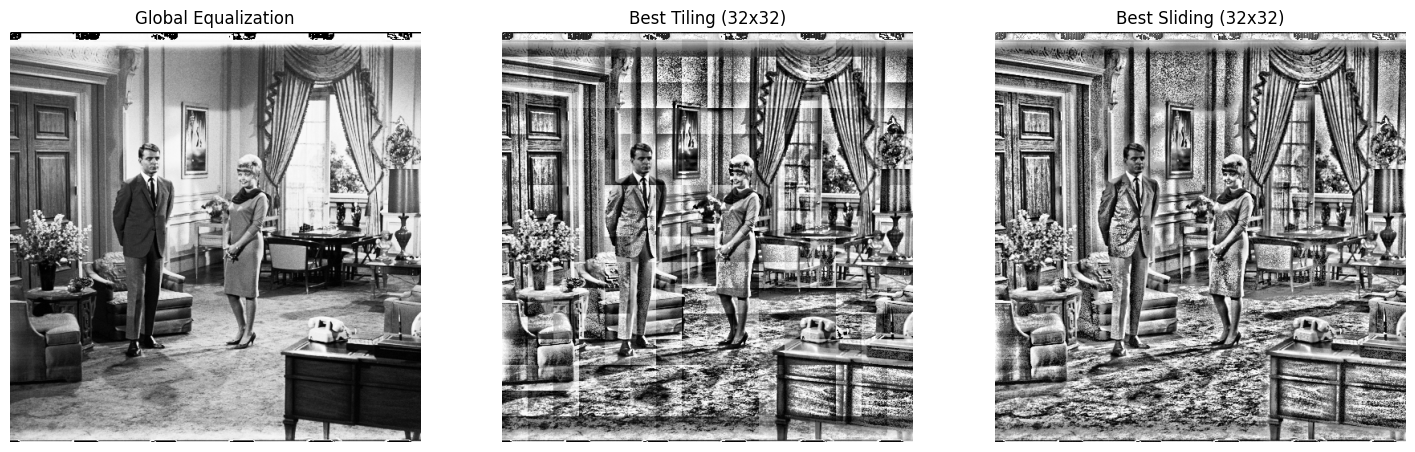

In [9]:
# ==========================
# Part 7: Final Visual Comparison - Global vs Tiling vs Sliding
# ==========================

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.title("Global Equalization")
plt.imshow(global_eq, cmap='gray'); plt.axis('off')

plt.subplot(1,3,2)
plt.title("Best Tiling (32x32)")
plt.imshow(tiling_results[32], cmap='gray'); plt.axis('off')

plt.subplot(1,3,3)
plt.title("Best Sliding (32x32)")
plt.imshow(sliding_results[32], cmap='gray'); plt.axis('off')

plt.show()
